In [1]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import glob
import matchms
from matchms.plotting import plot_spectra_mirror
from scipy.optimize import curve_fit
import random

matchms.set_matchms_logger_level("ERROR")

In [2]:
sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)

def to_matchms_spec(s):
    mzp = np.nonzero(s)[0]
    intp = s[mzp]
    return matchms.Spectrum(mz=mzp.astype(float), intensities = intp.astype(float))


In [ ]:
fname = 'checkpoints/small.80173081.validate_.00000600.output'

with open(fname,'rb') as f:
    p = pk.load(f)

In [ ]:
p.keys()

In [ ]:
def to_matchms_spec(s):
    mzp = np.nonzero(s)[0]
    intp = s[mzp]
    return matchms.Spectrum(mz=mzp.astype(float), intensities = intp.astype(float))

idx = 42
spp = to_matchms_spec(p['pred_spect'][idx])
spt = to_matchms_spec(p['pred_true_spect'][idx])

plot_spectra_mirror(spp,spt)


In [ ]:
matchms.set_matchms_logger_level("ERROR")

true = p['pred_true_spect']
pred = p['pred_spect']
n = len(true)

sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
dp = np.array([ float(s['score']) for s in dp ])

sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)
sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
sdp = np.array([ float(s['score']) for s in sdp ])


In [ ]:
win = 50
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='dp')
plt.plot(smooth_sdp,label='sdp')
plt.legend()
#plt.plot([ float(s['matches']) for s in scores ])
plt.show()

In [ ]:
np.mean(dp),np.std(dp)

In [3]:
dps = {}
sdps = {}


In [4]:
for fn in sorted(glob.glob('checkpoints/*validate*.output')):
#for fn in sorted(glob.glob('checkpoints/*train*.output')):
    if fn in dps:
        continue
        
    with open(fn,'rb') as pf:
        p = pk.load(pf)
    
    true = p['pred_true_spect']
    pred = p['pred_spect']
    n = len(true)

    dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
    dps[fn] = np.array([ float(s['score']) for s in dp ])
     
    sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
    sdps[fn] = np.array([ float(s['score']) for s in sdp ])
    


    

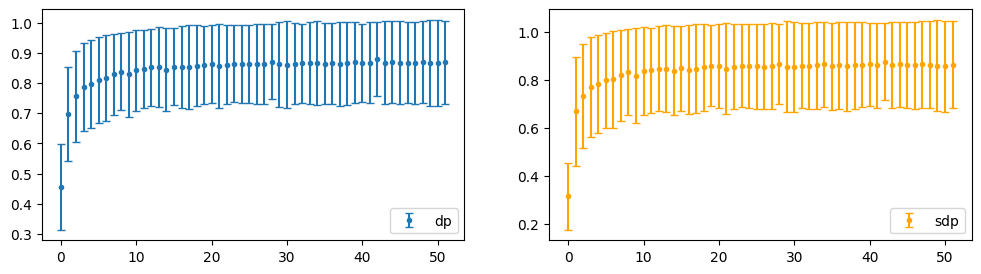

In [5]:
mean_dps = [ np.mean(dps[f]) for f in sorted(dps.keys()) ]
std_dps = [ np.std(dps[f]) for f in sorted(dps.keys()) ]
mean_sdps = [ np.mean(sdps[f]) for f in sorted(sdps.keys()) ]
std_sdps = [ np.std(sdps[f]) for f in sorted(sdps.keys()) ]

median_dps = [ np.median(dps[f]) for f in sorted(dps.keys()) ]

plt.figure(figsize=(12,3))
l = len(dps)
plt.subplot(121)
plt.errorbar(x=range(l),y=mean_dps,yerr=std_dps,label='dp',linestyle='None', marker='.',capsize=3)
plt.legend()
plt.subplot(122)
plt.errorbar(x=range(l),y=mean_sdps,yerr=std_sdps,label='sdp',color='orange',linestyle='None', marker='.',capsize=3)
plt.legend()
plt.show()


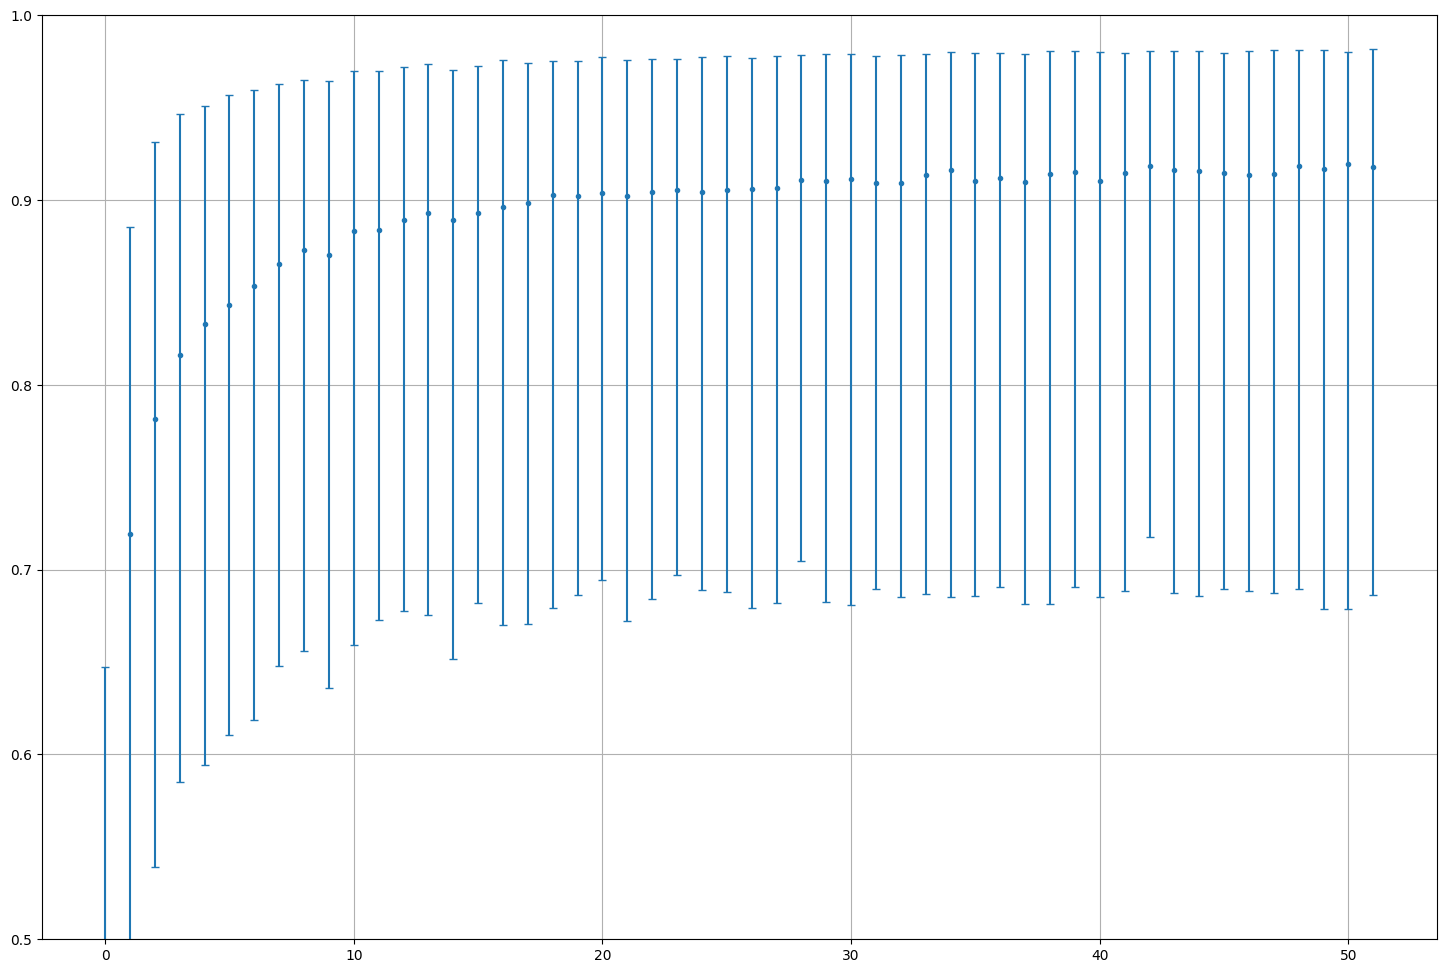

In [6]:
dpss = np.stack([ dps[f] for f in sorted(dps.keys()) ])
dpss = np.sort(dpss)
bs = dpss.shape[1]
dpss_median = np.median(dpss,axis=1)
dpss_percentile = dpss[:,(int(bs*.1), int(bs*.9))].T

plt.figure(figsize=(18,12))
plt.grid()
plt.ylim(0.5,1)
plt.errorbar(x=range(dpss.shape[0]),
             y=dpss_median,yerr=np.abs(dpss_percentile-dpss_median),
             linestyle='None',marker='.',capsize=3)
plt.show()

In [11]:
i=np.argmax(mean_dps)
i,mean_dps[i],std_dps[i]

(42, 0.878343575145607, 0.1224385993986933)

In [8]:
i=np.argmax(mean_sdps)
i,mean_sdps[i],std_sdps[i]

(42, 0.8762168571711995, 0.16098294561106838)

In [9]:
i=np.argmax(median_dps)
i,median_dps[i]

(50, 0.9195061872368483)

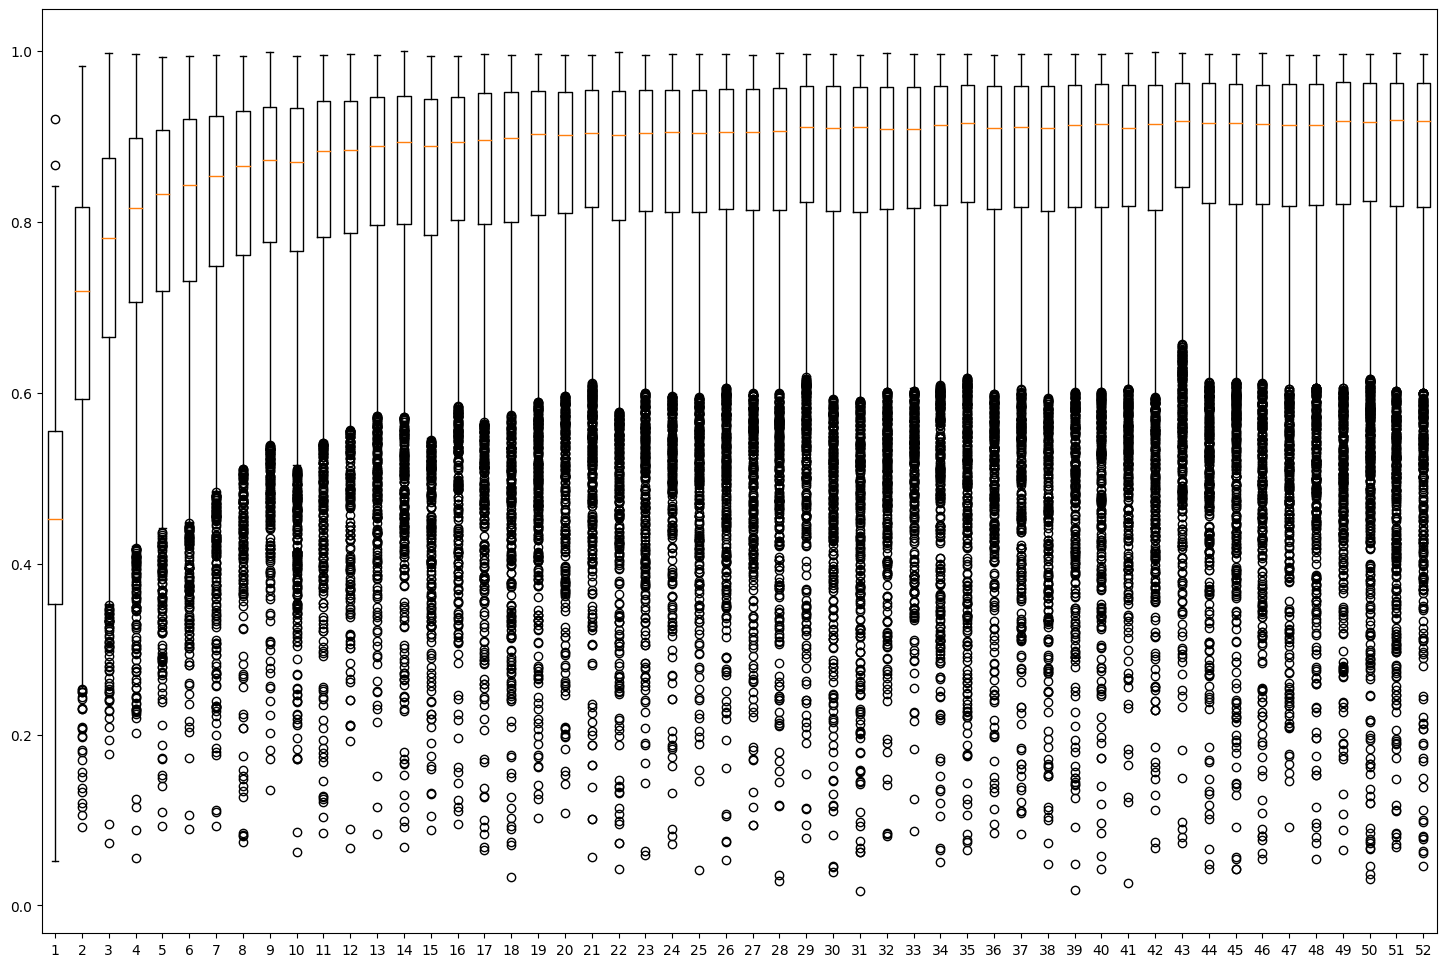

In [10]:
plt.figure(figsize=(18,12))
plt.boxplot(dpss.T)
plt.show()

In [ ]:
with open(sorted(dps.keys())[i],'rb') as pf:
    p = pk.load(pf)

In [ ]:
idx = random.randint(0,4095)
spp = to_matchms_spec(p['pred_spect'][idx])
spt = to_matchms_spec(p['pred_true_spect'][idx])

print(idx)
plt.figure(figsize=(18,12))
plot_spectra_mirror(spt,spp)
plt.show()

In [ ]:
len(dps)

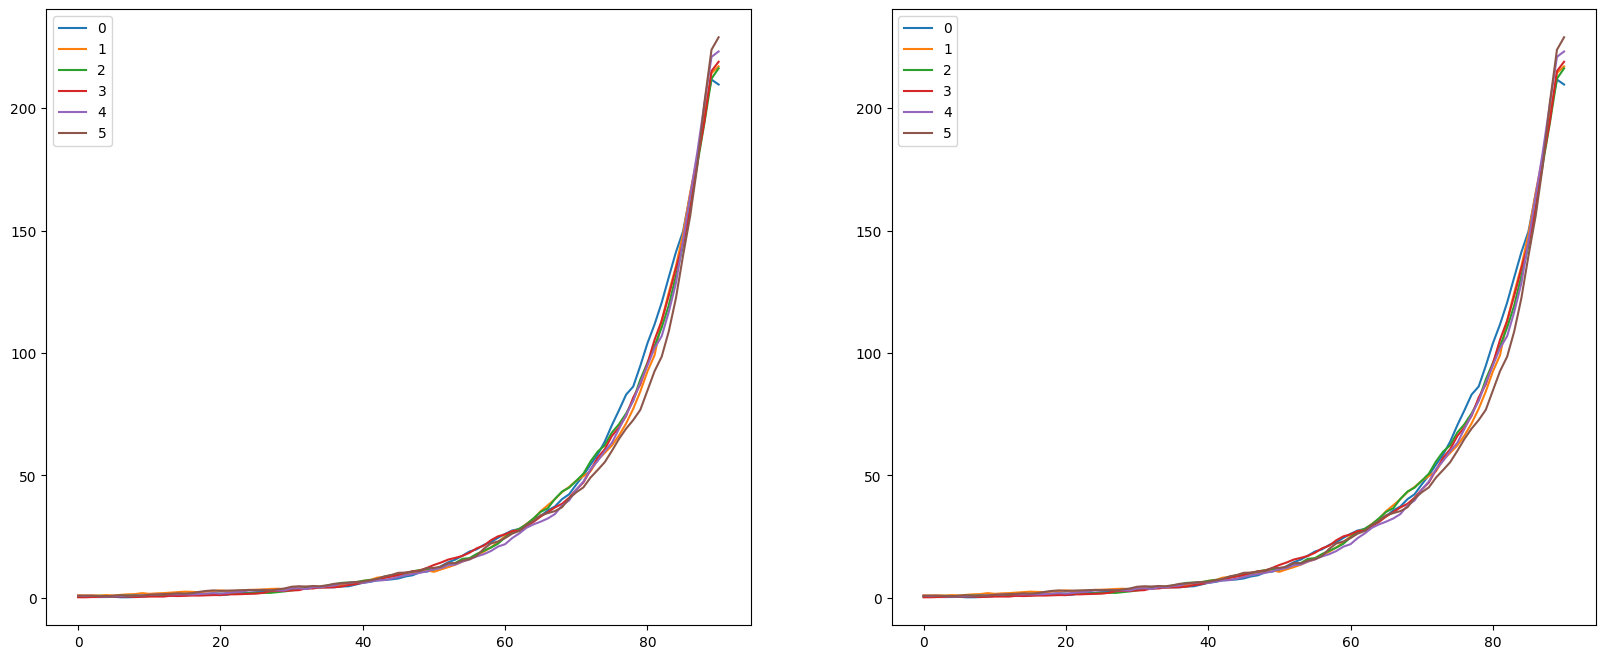

In [12]:
bins = 100
plt.figure(figsize=(20,8))

win=10
first=25
step=5
plt.subplot(121)
for i,fn in enumerate(sorted(dps.keys())[first::step]):
    counts, bins = np.histogram(dps[fn],bins=bins)
    counts = np.convolve(counts, np.ones(win)/win, mode='valid')
#    plt.stairs(counts, bins, label=str(i))
    plt.plot(counts,label=str(i))

plt.legend()

plt.subplot(122)
for i,fn in enumerate(sorted(dps.keys())[first::step]):
    counts, bins = np.histogram(dps[fn],bins=bins)
    counts = np.convolve(counts, np.ones(win)/win, mode='valid')
#    plt.stairs(counts, bins, label=str(i))
    plt.plot(counts,label=str(i))

    
plt.legend()
plt.show()

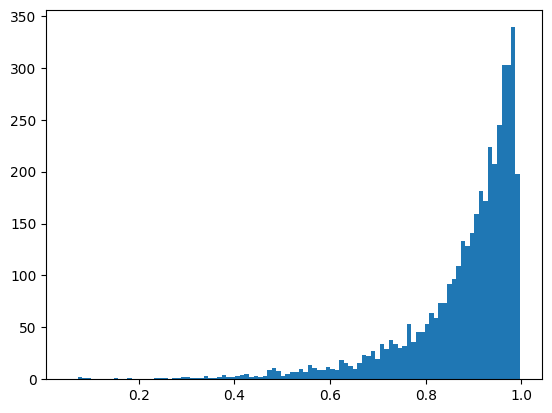

In [13]:
dp_best = dps[list(sorted(dps.keys()))[42]]

plt.hist(dp_best,bins=bins)
plt.show()

In [ ]:
def expf(x,a,b):
    return b*np.exp(a*x)

e = []

for fn in sorted(dps.keys()):

    x = np.linspace(0,99,100)
    #dphist = np.flip(np.histogram(dps[fn],bins=100)[0])
    dphist = np.flip(np.histogram(dps[fn],bins=100)[0])

    e.append(curve_fit(expf,x,dphist,[-1.,200.])[0])
    
e = np.array(e)

plt.plot(e[:,0],label='exp')
#plt.plot(e[:,1],label='scale')
plt.legend()

plt.show()

In [ ]:
plt.plot(x,dphist)
plt.show()

In [ ]:
dphist

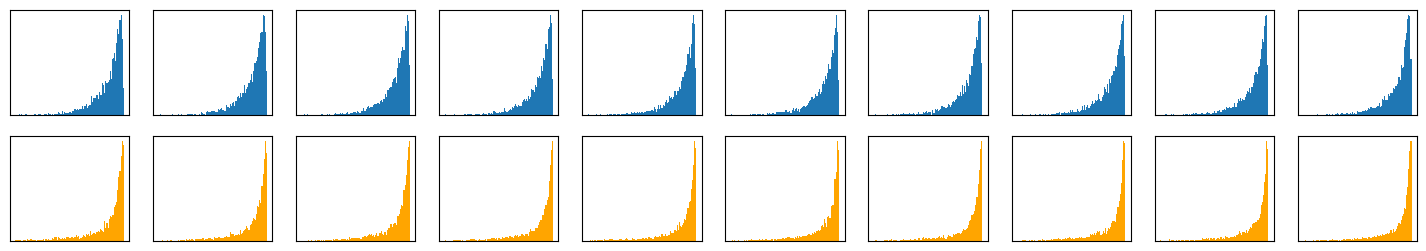

In [247]:
bins = 100
plt.figure(figsize=(20,3))

first=21
step=2
l = (len(dps)-first)//step+1
for i,fn in enumerate(sorted(dps.keys())[first::step]):
    plt.subplot(2,l,i+1)
    plt.hist(dps[fn],label='dp',bins=bins)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2,l,l+i+1)
    plt.hist(sdps[fn],label='sdp',bins=bins,color='orange')
    plt.xticks([])
    plt.yticks([])
#lt.legend()
plt.show()

In [ ]:
import pandas as pd
smalltrain = pd.read_parquet('smalltrain.pq')
smalltrain

In [ ]:
len(smalltrain)/4096/1400

In [ ]:
4096*1400/len(smalltrain)